# Chaîne de traitement _data science_.
## _Classification_ avec `python` ([`scipy`](https://www.scipy.org/), [`scikit-learn`](https://scikit-learn.org/)) 


|Auteur|Centre|Modification|
|---|---|---|
|P. Halftermeyer|Orléans|2018/11/17|

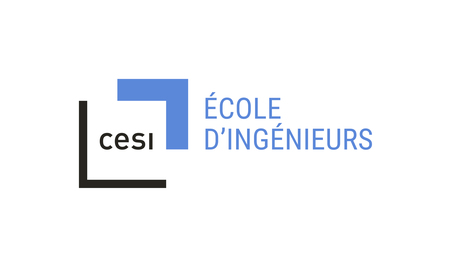

__Dépendance__ : Ce Workshop doit être réalisé après ceux sur le _data wrangling_ et le _pipeline ML_ .

Après avoir étudier un problème de _régression_, nous allons maintenant nous intéresser à l'autre grand type de tâches supervisées du _ML_, à savoir la _classification_. 

# Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# MNIST

On va travailler sur le _dataset_ [_MNIST_](https://fr.wikipedia.org/wiki/Base_de_donn%C3%A9es_MNIST). C'est une base de données de chiffres manuscrits. La base MNIST s'est affirmée comme un standard du _ML_. Dans sa version originale, elle regroupe 60000 images d'apprentissage et 10000 images de test, issues d'une base de données antérieure, appelée simplement NIST1. Ce sont des images en noir et blanc, carrées, normalisées centrées de 28 pixels de côté.

Nous allons le télécharger et charger le fichier [`.mat`](https://docs.scipy.org/doc/scipy/reference/tutorial/io.html) en mémoire:

In [2]:
from six.moves import urllib
from scipy.io import loadmat

mnist_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
response = urllib.request.urlopen(mnist_url)
with open(mnist_path, "wb") as f:
    content = response.read()
    f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,     #X
    "target": mnist_raw["label"][0], #Y
    "COL_NAMES": ["label", "data"], 
    "DESCR": "mldata.org dataset: mnist-original",
}
print("Success!")

Success!


Faisons connaissance avec ce _dataset_.

In [3]:
mnist

{'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original'}

Le jeu de données est un dictionnaire constitué de :
- Un tableau `data` dont chaque instance est une ligne et chaque _feature_ est une colonne
- Un tableau d'étiquettes `targets`
- Une description `DESCR` et la liste des noms des champs du _dataset_ `COL_NAMES`

Allons plus en détail :

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
28*28

784

In [7]:
some_digit = X[36000] #random digit, any others works too
some_digit

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,  86, 131, 225, 225, 225,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

- Les $70000$ instances de `data` sont des tableaux contenant chacun $28^2$ valeurs, manifestement des niveaux de gris contenus entre $0$ (blanc) et $255$ (noir).
- `target` est un tableau à une dimension de longueur $70000$ également.

On peut utiliser la fonction [`imshow`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html) de `matplotlib` pour afficher l'image correspondante.

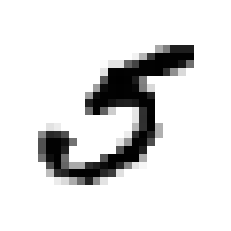

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

#save_fig("some_digit_plot")
plt.show()

L'image ressemble à un 5 manuscrit. Verifions qu'elle est bien étiquetée comme telle.

In [10]:
y[36000]

5.0

Présumant que nous allons souvent avoir besoin d'observer nos données en tant qu'image, nous définissons une fonction à cet effet :

In [11]:
def plot_digit(data):
    some_digit_image = data.reshape(28, 28)
    plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
    plt.axis("off")
    plt.show()

En bonus, on va représenter quelques échantillons de données sur une matrice :

In [12]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

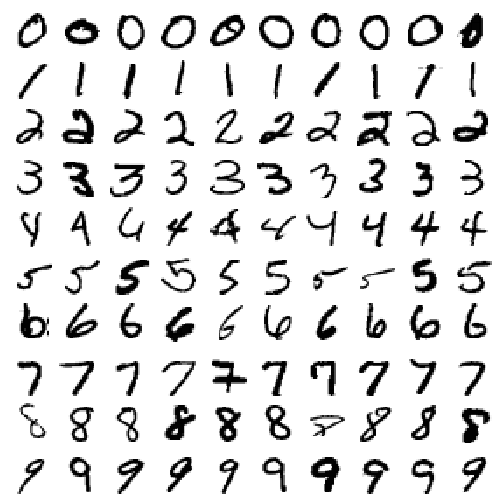

In [14]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

## Constitution du jeu de test et du jeu d'entraînement

Est-on déjà en train de tomber dans les travers du _data snooping_ ? Il serait en tout cas grand temps de constituer un jeu de données de test si `mnist` n'était pas déjà splitté en un jeu d'entraînement et un jeu de test.

In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Le _dataset_ semble ordonné. Nous allons mélanger les données pour éviter d'influencer nos algos.

> **Remarque** : Mélanger un jeu de données est une bonne chose ici, car on ne veut pas que les algos puissent apprendre de la position d'une image dans le _dataset_. Ce serait une très mauvaise idée si notre jeu de données était une série temporelle.

In [17]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Entraînement d'un classifieur binaire

C'est pour nous le premier exercice de _classification_. Nous allons dans un premier temps simplifier le problème en créant un _classifieur binaire_ prédisant si le digit représenté par une instance _est un $5$_ ou _n'est pas un $5$_. Nous créons pour cela à partir des anciennes deux nouveaux jeux d'étiquettes (`y_train_5` et `y_test_5`) à valeurs booléennes :

In [18]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Pour commencer, nous allons entraîner un classifieur par [_descente de gradient stochastique_](https://fr.wikipedia.org/wiki/Algorithme_du_gradient_stochastique) en utilisant le [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) de `scikit-learn`. Cet algorithme a pour principal atout de traiter chaque instance indépendamment, il est donc particulièrement adapté pour l'apprentissage _online_. Créons-le et entraînons-le sur le jeu d'entraînement.

In [24]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Notre modèle est maintenant prêt à prédire :

In [25]:
sgd_clf.predict([some_digit])

array([ True])

Notre chiffre est bien un $5$. La prédiction est valide. Nous devons néanmoins mesurer plus finement la performance de notre modèle.

## Mesurer la performance

### _Cross-validation_

Comme nous l'avons fait à plusieurs reprises dans le _workshop_ sur le _pipeline ML_, nous allons _cross_-valider notre modèle. Ci-dessous, nous réalisons ce travail _à la main_ afin de mettre l'accent sur la nécessité de stratifier notre découpe du jeu de donnée. Toutes les classes (`True` et `False`) doivent être représentées dans des proportions similaires d'un _fold_ à l'autre. Nous réalisons ensuite la même opération avec le [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) de `scikit-learn` qui utilise lui-aussi une stratification.

In [26]:
# cross-val a la mano
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))



0.9651
0.95615
0.9635


In [27]:
# ⨯-val avec scikit-learn
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9651 , 0.95615, 0.9635 ])

95 % ! C'est encourageant. Comparons maintenant ce résultat à celui d'un classificateur absurde classant toutes les instances qu'on lui propose dans la catégorie `pas 5`.

Il faut d'abord créer le classifieur :

In [30]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Puis en _cross_-valider une instance :

In [31]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.91135, 0.90795])

Notre classifieur semble à peine meilleur qu'un classifieur trivial. Ce que l'on peut en conclure, en premier lieu, c'est que cette mesure d'_accuracy_ n'est pas la bonne métrique pour le classifieur d'un [_skewed_](https://fr.wikipedia.org/wiki/Asym%C3%A9trie_(statistiques))-_dataset_.

### Matrice de confusion

La [_matrice de confusion_](https://fr.wikipedia.org/wiki/Matrice_de_confusion) est l'outil incontournable lorsqu'il s'agit d'étudier les performances d'un système de classification supervisé. Prenez le temps de lire l'article donné en lien.

Voici à quoi ressemble une matrice de confusion dans le cas général :

|_label_|classé $1$|classé $2$|classé $3$|...|classé $n$|
|---|---|---|---|---|---|
|**$1$**|**$1$ classés $1$**|_$1$ classés $2$_|_$1$ classés $3$_|...|_$1$ classés $n$_|
|**$2$**|_$2$ classés $1$_|**$2$ classés $2$**|_$2$ classés $3$_|...|_$2$ classés $n$_|
|**$3$**|_$3$ classés $1$_|_$3$ classés $2$_|**$3$ classés $3$**|...|_$3$ classés $n$_|
|...|...|...|...|...|...|
|**$n$**|_$n$ classés $1$_|_$n$ classés $2$_|_$n$ classés $3$_|...|**$n$ classés $n$**|

Puis dans le cas binaire :

|_label_|classé FAUX|classé VRAI|
|---|---|---|
|**FAUX**|**vrai NEGATIF**|_faux POSITIF_|
|**VRAI**|_faux NEGATIF_|**vrai POSITIF**|

Nous allons tâcher de calculer cette matrice pour notre classifieur.

|_label_|classé `non 5`|classé `5`|
|---|---|---|
|`non 5`|**vrai NEGATIF**|_faux POSITIF_|
|`5`|_faux NEGATIF_|**vrai POSITIF**|

On utilise pour cela [`cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html). Cette fonction permet d'obtenir, pour chaque _fold_ du jeu d'entraînement, les prédictions obtenues en apprenant sur le reste des données.

In [32]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

On peut maintenant calculer la matrice de confusion avec [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53110,  1469],
       [  836,  4585]])

Ci-dessous, on peut la comparer à la matrice de confusion qui serait produite par un classifieur parfait :

In [34]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

La matrice de confusion est riche en informations, mais nous avons pris l'habitude de chercher à obtenir un score. Il est d'usage de s'intéresser d'une part à la _précision_ et de l'autre au _recall_ pour un classifieur binaire.

$$
\newcommand\TP{\mbox{TP}}
\newcommand\TN{\mbox{TN}}
\newcommand\FP{\mbox{FP}}
\newcommand\FN{\mbox{FN}}
\newcommand\precision{\mbox{precision}}
\newcommand\recall{\mbox{recall}}
$$

La _precision_ est l'_accuracy_ des prédictions positives :

$$
\precision = \frac{\TP}{\TP+\FP}
$$

Le _recall_ est le _ratio_ de positifs correctement classifiés :

$$
\recall = \frac{\TP}{\TP+\FN}
$$

Il serait aisé d'obtenir trivialement des classifieurs parfaits pour l'une ou l'autre de ces métriques. Il sont donc peu pertinent si on les considère individuellement. En revanche, chercher à satisfaire ces deux indicateurs simultanément est une bonne stratégie.

### Précision et _recall_

On peut calculer la _precision_ et le _recall_ grâce à `scikit-learn` :

In [35]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.7573505120581434

In [36]:
4344 / (4344 + 1307)

0.7687135020350381

In [37]:
recall_score(y_train_5, y_train_pred)

0.845784910533112

In [38]:
4344 / (4344 + 1077) # vérification du score

0.801328168234643

Nous lisons bien, quand notre _5-classifieur_ affirme qu'un chiffre est un 5, il n'est dans le vrai que 77% des fois. De plus, il ne détecte que 80% des 5. Nous avons eu raison de ne pas trop nous enthousiasmer pour les 95% d'accuracy !

Il est fréquent d'utiliser la [_moyenne harmonique_](https://fr.wikipedia.org/wiki/Moyenne_harmonique) de la _precision_ et du _recall_ comme métrique _unifiée_. La moyenne hamonique a comme atout de donner beaucoup de poids au valeurs faibles, ce qui n'autorise un score élevé que si les deux mesures de bases le sont. On appelle ce score le $F_1$-score.

$$
F_1 = \frac{2}{\frac{1}{\precision}+\frac{1}{\recall}} = 2 \times \frac{\precision \times \recall}{\precision + \recall} = \frac{\TP}{\TP+\frac{\FN+\FP}{2}}
$$

On peut le calculer sans effort avec `scikit-learn`.

In [39]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.799128540305011

Le $F_1$-score favorise le fait d'avoir une _precision_ et un _recall_ proches l'un de l'autre. Cela dit l'indicateur doit être choisi en fonction de l'objectif. Par exemple, un détecteur de contenus appropriés aux enfants pourra se permettre plus facilement des faux négatifs que des faux positifs (_recall_ bas et _precision_ élevée). Il faut trouver le juste _precision/recall tradeoff_.

Pour aller dans ce sens, on s'intéresse à la façon dont le `SGDClassifier` effectue ses décision. Pour chaque instance, une _fonction de décision_ calcule un score. Si ce score dépasse un seuil (_threshold_) donné, on attribut une étiquette positive à l'instance. On peut jouer sur la valeur de ce seuil pour établir cet équilibre.

`Scikit-learn` ne donne pas accès à ce seuil mais nous pouvons appeler la fonction de décision.

In [40]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3786.91976651])

In [41]:
threshold = 0 # seuil par défaut du classifier
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [42]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Le chiffre n'est plus reconnu comme `5` avec un tel seuil. On peut se convaincre que réhausser le seuil abaisse le _recall_. Comment choisir ce seuil ? On va d'abord calculer (_via_ `cross_val_predict`) les résultats de la fonction de décision pour tout notre jeu d'entraînement.

In [43]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [44]:
y_scores.shape

(60000,)

C'est l'occasion de vérifier que les prédictions anterieures avaient bien été calculées avec un seuil égal à zéro :

In [46]:
(y_train_pred == (y_scores > 0)).all() # le seuil est-il bien fixé à zéro ?



True

On peut maintenant calculer la _precision_ et le _recall_ pour tous les seuils possible. On utilise [`precision_recall_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html)

In [47]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

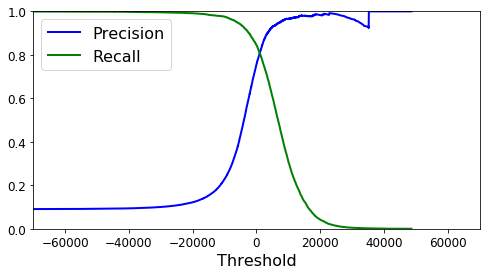

In [50]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-70000, 70000])
#save_fig("precision_recall_vs_threshold_plot")
plt.show()

Ce graphique nous permet de fixer le seuil en fonction du compromis que nous souhaitons obtenir.

Une autre approche est de confronter graphiquement la _precision_ et le _recall_.

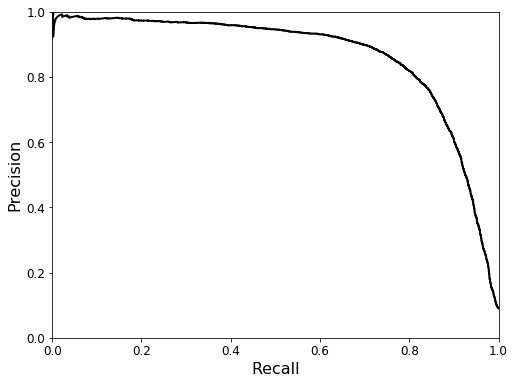

In [51]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "k-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
#save_fig("precision_vs_recall_plot")
plt.show()

On constate une chute importante de la _precison_ autour de 75% de _recall_. Il pourra sembler habile, selon le projet, de choisir un seuil assurant un _recall_ en dessous de cette valeur.

Admettons que l'on vise une _précision_ aux alentours de 90%. On peut fixer le seuil en utilisant nos graphiques :

In [52]:
y_train_pred_90 = (y_scores > 70000)

precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

/home/ced/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.0, 0.0)

On peut obtenir un classifieur de précision arbitrairement élevée en jouant sur le seuil. La question à se poser systématiquement est l'impact sur le _recall_.

### Courbe ROC

La [_courbe ROC_](https://fr.wikipedia.org/wiki/Courbe_ROC) est un autre moyen d'évaluer un classifieur binaire. Elle confronte le _taux de vrai positif_ (_TPR_ ou _recall_) au [_taux de faux positif_](https://en.wikipedia.org/wiki/False_positive_rate) (_FPR_).
$$
\newcommand\TPR{\mbox{TPR}}
\newcommand\FPR{\mbox{FPR}}
$$
On se souvient de la formule du _recall_, soit de celle du _TPR_ :
$$
\TPR = \frac{\TP}{\TP+\FN}
$$
Et de même on a celle du _FPR_ :
$$
\FPR = \frac{\FP}{\TN+\FP}
$$
Nous allons tâcher de construire cette courbe.

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

Encore une fois, c'est une affaire de compromis. Un grand taux de vrais positifs implique beaucoup de faux positifs. La diagonal en pointillé représente la ROC d'un classifier aléatoire. Un classificateur idéal s'en écarte au maximum en épousant le coin supérieur gauche. C'est pourquoi on utilise comme métrique de comparaison l'_air sous la courbe_ ROC, que l'on souhaite la plus proche possible de $1$. Nous allons la calculer avec [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).

In [ ]:
#CODE A COMPLETER

#CODE A COMPLETER

> **Remarque** : la courbe _precision_ / _recall_ est un meilleur indicateur quand les positifs sont rares ou quand on cherche à éviter les faux positifs. La courbe _ROC_ est a privilégier dans les autres cas.

## Comparaison de deux modèles

###  _random forest classifier_

On désire comparer notre modèle à un _random forest classifier_. Il est a noté que ce modèle ne met pas de `decision_function()` à disposition de l'utilisateur mais plutôt une fonction `predict_proba()` qui retourne une liste de probabilités pour chaque classe, et ce pour chaque instance. La plupart des classifieurs disposent de l'une ou l'autre de ces fonctions.

Nous allons utiliser `predict_proba()` pour construire une courbe _ROC_.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    #CODE A COMPLETER

In [ ]:
y_probas_forest

Il nous faut calculer un score. Nous allons considérer la probabilité de la classe positive (deuxième colonne) puis appliquer `roc_curve`.

In [ ]:
#CODE A COMPLETER
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Nous pouvons maintenant comparer nos courbes :

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

On est beaucoup plus proche du coin, ce qui est prometteur. Calculons l'_AUC_ :

In [ ]:
#CODE A COMPLETER

C'est encore un beau score. On constatera que _precision_ et _recall_ ne sont pas mal non plus : 

In [ ]:
#CODE A COMPLETER #cross_val_predict
#CODE A COMPLETER #precision

In [ ]:
#CODE A COMPLETER #recall

Nous savons maintenant entraîner et évaluer des classifieurs binaires. Il est temps de passer en multi-classe !

## Classification multi-classe

Il existe des algorithmes naturellement multi-classes tels que les random forest ou les classificateurs bayesiens. Pour les autres (_SVM_, _classifieurs linéaires_, _etc_), une stratégie est d'utiliser un _classifieur_ par classe et de choisir celle ou le score de décision et le plus grand. C'est la stratégie _one-versus-all_ (_OvA_).

Une autre startégie est de construire un _classifieur_ binaire pour toute paire de classes(qui distingue les `1` et les `4`, les `7` et les `2`, _etc_.) C'est la stratégie _one-versus-one_ (_OvO_). Pour $n$ classes, on entraînera $\frac{n \times (n-1)}{2}$ classifieurs. Soit $45$ pour _MNIST_. C'est beaucoup mais il suffit de les entraîner sur la sous-partie du jeu de donnée correspondant aux classes à distiguer. C'est une stratégie qui convient bien aux algorithmes qui passent mal à l'échelle des jeux de données volumineux (comme _SVM_).

En revanche, pour la plupart des algorithmes de classification binaire, on préferera _OvA_ (par défaut avec Scikit-learn sauf pour SVM).

### Stratégie _OvA_

Essayons avec notre `SGCDClassifier` :

In [ ]:
sgd_clf.fit(X_train, y_train) # y_train ET NON y_train_5
sgd_clf.predict([some_digit])

Facile. La fonction `fit()` a appliqué une startégie _OvA_. Et la prédiction est bonne.

Pour s'en convaincre, on peut appeler la fonction de décision et simuler la prédiction :

In [ ]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

In [ ]:
class_max_index = np.argmax(some_digit_scores)
class_max_index

In [ ]:
sgd_clf.classes_

In [ ]:
sgd_clf.classes_[class_max_index]

### Stratégie _OvO_

Essayons maintenant la deuxième stratégie :

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

In [ ]:
len(ovo_clf.estimators_)

### Forêt aléatoire

Pas d'_OvA_ ni d'_OvO_ pour cet algorithme nativement multiclasse.

In [ ]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

In [ ]:
forest_clf.predict_proba([some_digit])

Pas mal. 80 % de chance d'avoir un $5$.

### Cross-validation

Evaluons un modèle par _cross-validation_.

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

C'est pas mal (un classifier random aurait approx. 10% d'_accuracy_.
On peut tenter de faire du _scaling_ (comme dans les _workshops_ précédents) pour améliorer la solution.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

C'est un réel progrès que nous pouvons mesurer.

### Analyse d'erreur

Supposons qu'après benchmark et tuning fin, on cherche à analyser les erreurs commise par un modèle. Affichons la matrice de confusion :

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C'est un peu indigeste. Votre oeil préfère sans doute les images (voire les couleurs).

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

En exercice, utilisez [`matshow`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.matshow.html) pour mettre un peu de couleur à la visualisation de cette matrice :

In [ ]:
def plot_confusion_matrix(matrix):
    #CODE A COMPLETER
    #CODE A COMPLETER
    #CODE A COMPLETER
    #CODE A COMPLETER

plot_confusion_matrix(conf_mx)

Tout a l'air correct. La diagonale est peuplée et le reste l'est peu. La classe `5` est légèrement plus sombre. Cela peut signifier que la classification se fait moins bien ou tout simplement que le jeu de données contient moins de 5.

Nous allons tâcher de mettre en évidence les erreurs en divisant chaque valeur par le nombre d'images dans la classe correspondante. On comparera plus aisément des taux plutôt que des quantités.

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

In [ ]:
plot_confusion_matrix(norm_conf_mx)

C'est plus clair. On a maintenant une vue bien plus précise des erreurs qui sont commises. Par exemple, la colonne de la classe `8` est assez claire, on sait que beaucoup d'images sont considérées comme des 8 par erreur.

On voit aussi que beaucoup de 3 sont classés dans `5`. Cela nous incite à afficher une partie des effectifs des classes `3` et `5` dans la configuration de la matrice de confusion.

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

L'observation de ces images nous incite à considérer de nouvelles stratégies :
- On utilise un algo linéaire qui donne un poids à chaque pixel. Ça ne permet pas de palier certaines petites imperfection.
- On pourrait utiliser un preprocessing (centrage, rotations, _etc_) pour faciliter l'apprentissage.
- _etc_.



## Classification multilabel

Le besoin d'attribuer plusieurs labels à une même instance peut exister. On peut imaginer un algorithme de reconnaissance faciale reconnaissant 5 personnes sur la même photographie. Nous allons nous contenter aujourd'hui de créer un modèle décidant si un chiffre manuscrit est supérieur ou égal à 7 (`large`) et impair (`odd`).

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#CODE A COMPLETER # On construit y_train_large à partir de y_train
#CODE A COMPLETER # De même pour y_train_odd
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit])

In [ ]:
# ATTENTION : calcul exigeant (des heures) selon hardware
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
# f1_score(y_multilabel, y_train_knn_pred, average="macro") # average="weighted" si classes déséquilibrées

# resultat : 0.977 approx

## Classification multi-sorties

Nous allons créer un nouveau jeu de données à partir du précédent. Nous allons bruiter aléatoirement les images pour obtenir des images _sales_, puis nous considèrerons les images d'origine comme _cible_ de notre apprentissage.

In [ ]:
# On génère un bruit sur les images:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Nous pouvons maintenant entraîner un modèle (ici [$k$-_plus-proches-voisins_](https://fr.wikipedia.org/wiki/M%C3%A9thode_des_k_plus_proches_voisins)) à nettoyer nos images. Nous utilisons une image du jeu de test pour l'exemple.

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)

In [ ]:
#CODE A COMPLETER # Nettoyer c'est prédire
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

In [ ]:
other_index = 2312
#CODE A COMPLETER # Nettoyer c'est prédire
plt.subplot(121); plot_digit(X_test_mod[other_index])
plt.subplot(122); plot_digit(clean_digit)

Le résultat est plutôt convainquant !